In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    # "/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_Pilot",
    "/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_CrossEntropy",
]

df_list = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list.append(df)
    except Exception as e:
        print(e)
df = pd.concat(df_list)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# Only keep the epochs every 10 to reduce the number of points
df = df[df['epoch'] % 10 == 0]

In [4]:
for ikey in df.keys():
    print(ikey)

phase
epoch
loss
dice_score
ece_loss
edge_ece_loss
data
in_channels
out_channels
preload
train_splits
val_splits
version
batch_size
num_workers
pin_memory
seed
loss_func
batch_reduction
from_logits
model
convs_per_block
dims
filters
optim
lr
epochs
eval_freq
path


In [5]:
def calibrator(path):
    if 'SVLS' in str(path):
        return 'SVLS'
    else:
        return 'None'
    
df.augment(calibrator)

In [6]:
df['path'].unique()

array([PosixPath('/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_CrossEntropy/20240908_215937-DJRW-3944c466aeada84f88bfe9dd97d9ad2c'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_CrossEntropy/20240908_215950-YL8Q-711538429041e3a76abd0300eb6318d1'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_CrossEntropy/20240908_215958-GOO8-95ce77abfbe1e35eb2689c946b3da7a5'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_CrossEntropy/20240908_215942-9BBF-aea50bf0c1a6dad76dd3f3206a9e0a68')],
      dtype=object)

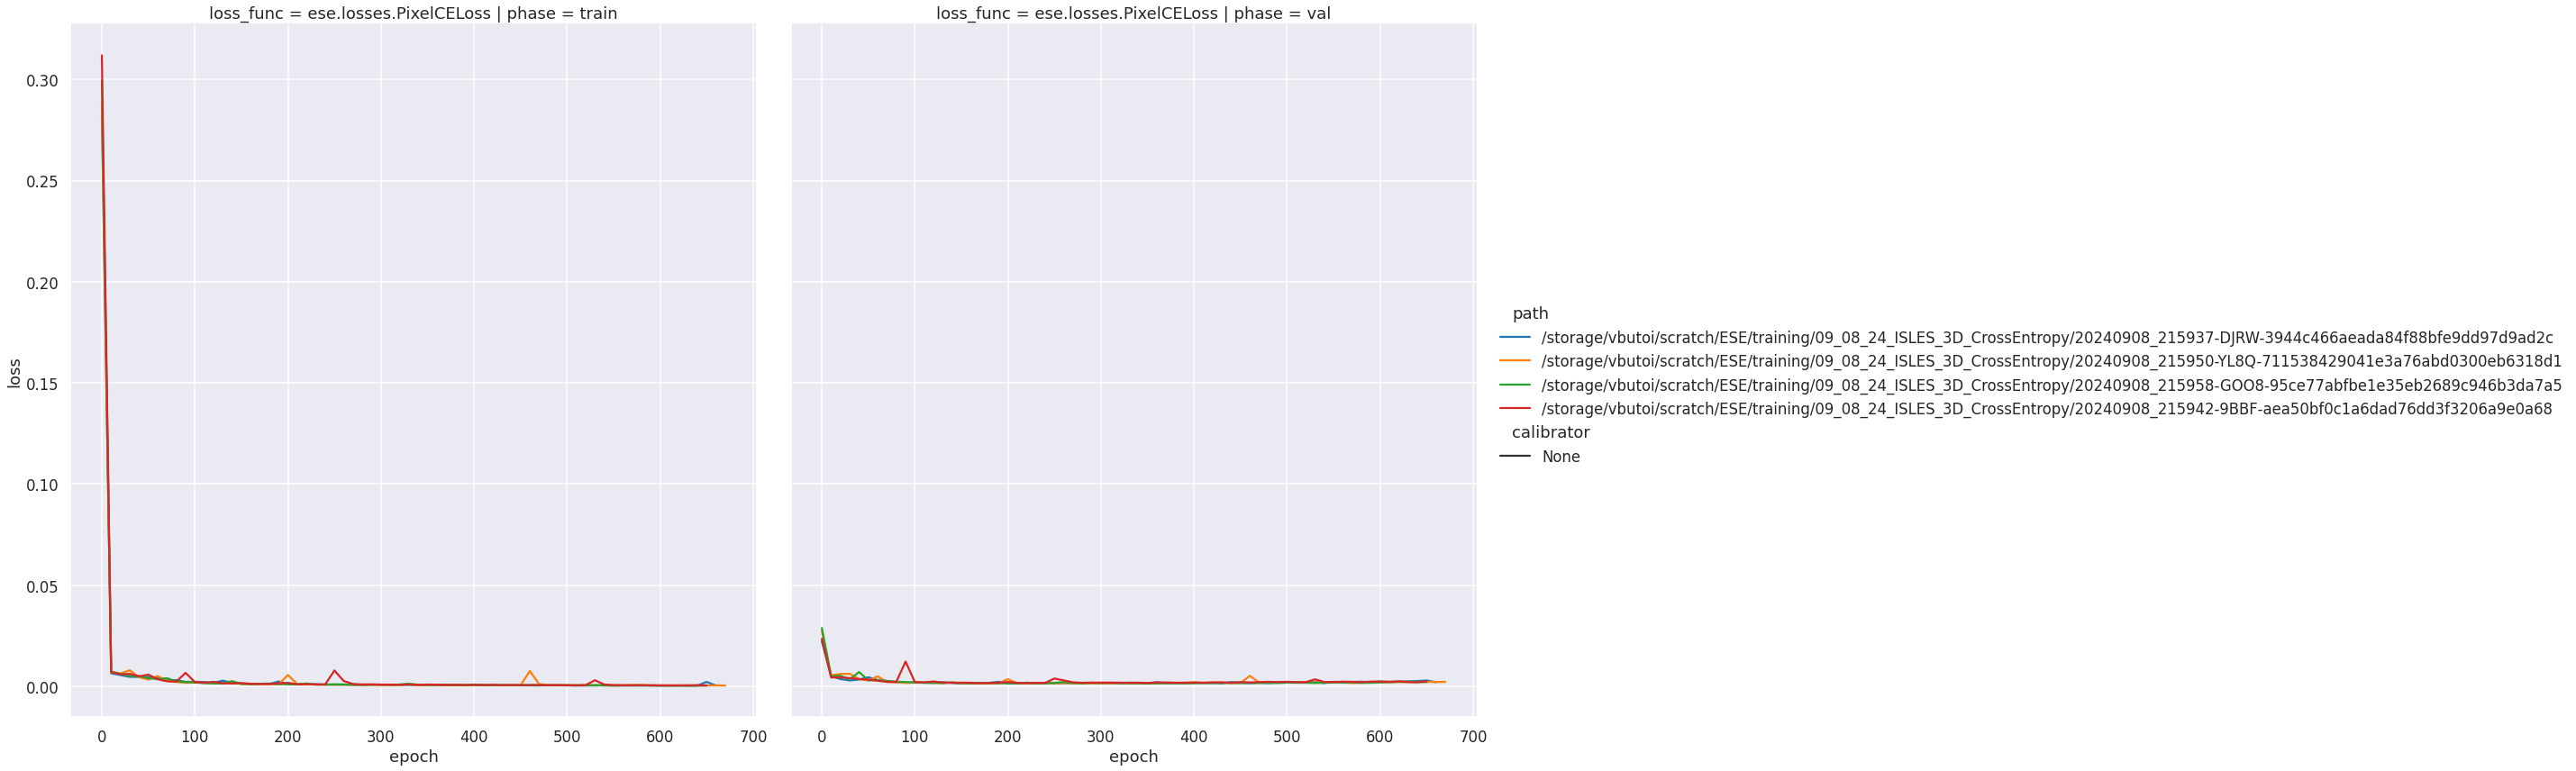

In [7]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='path',
    style='calibrator',   
    col='phase',
    row='loss_func',
    kind='line',
    height=12,
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

In [8]:
df.select(loss_func='ese.losses.PixelCELoss')['path'].unique()

array([PosixPath('/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_CrossEntropy/20240908_215937-DJRW-3944c466aeada84f88bfe9dd97d9ad2c'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_CrossEntropy/20240908_215950-YL8Q-711538429041e3a76abd0300eb6318d1'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_CrossEntropy/20240908_215958-GOO8-95ce77abfbe1e35eb2689c946b3da7a5'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_08_24_ISLES_3D_CrossEntropy/20240908_215942-9BBF-aea50bf0c1a6dad76dd3f3206a9e0a68')],
      dtype=object)

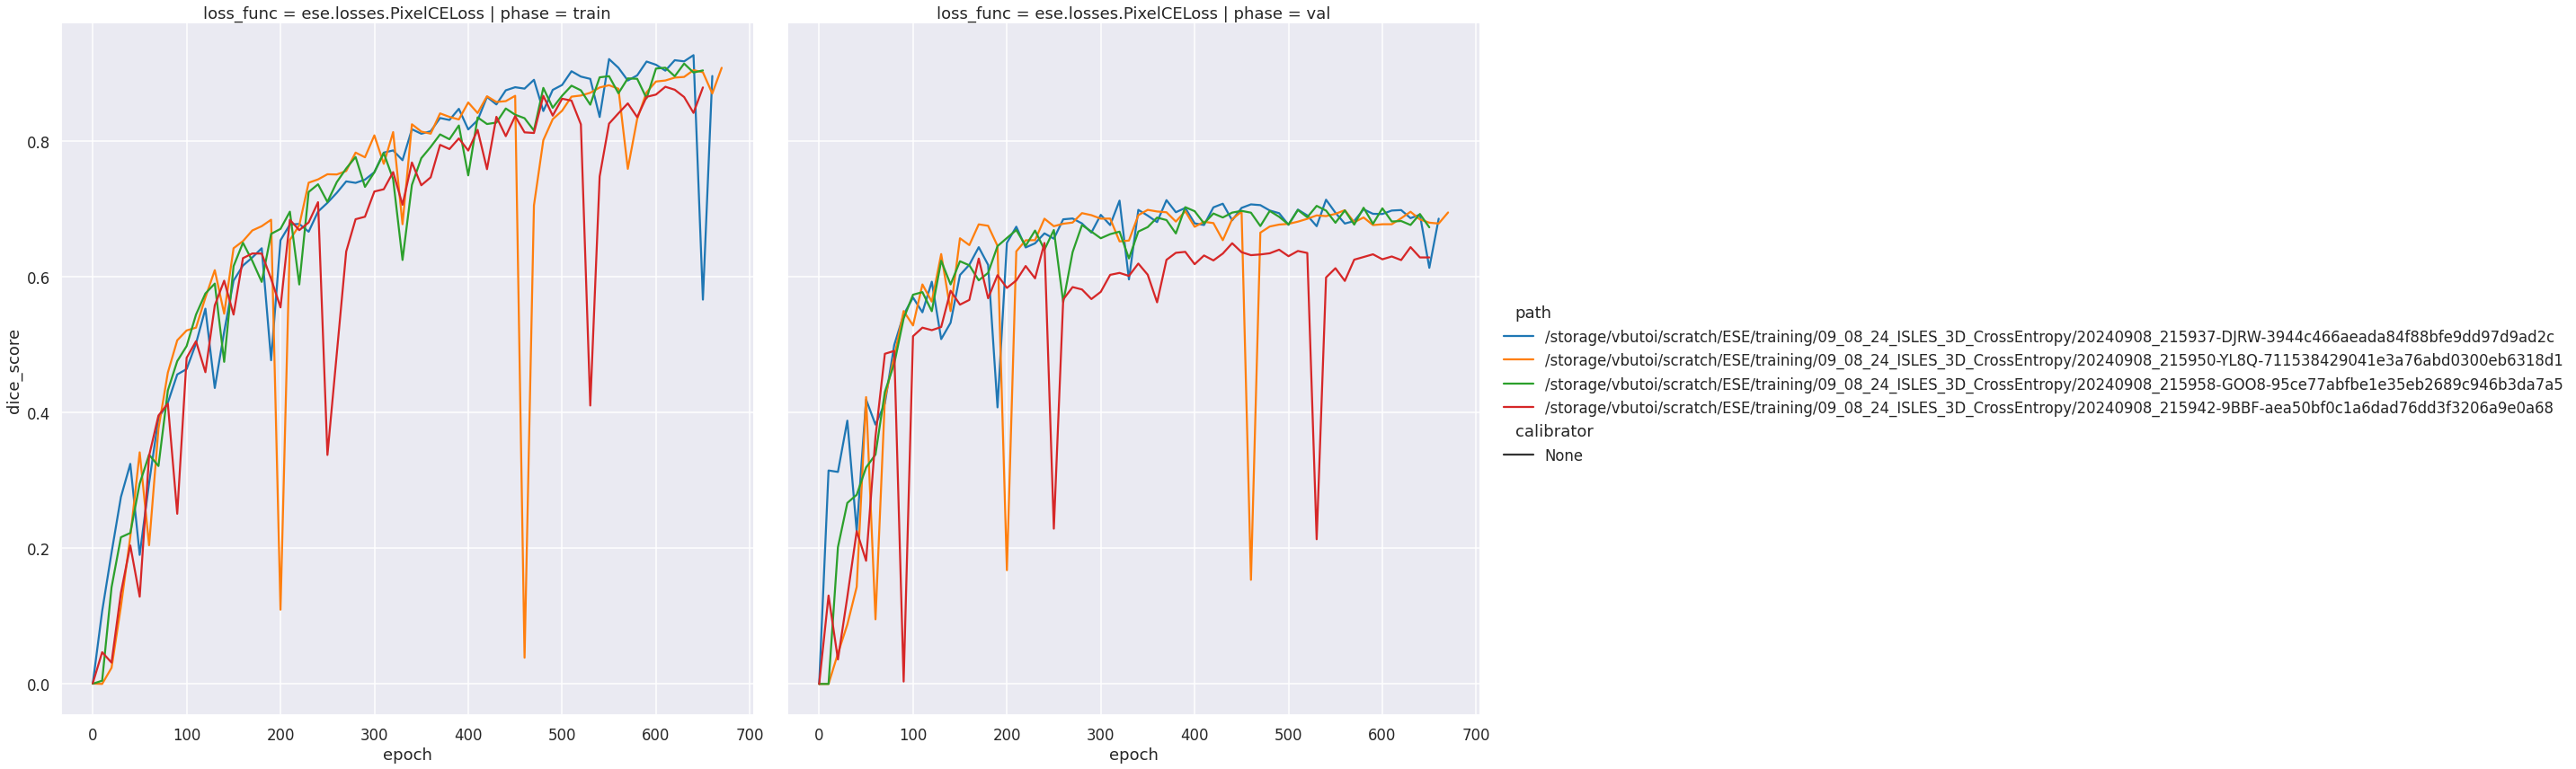

In [9]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='dice_score',
    hue='path',
    # hue='seed',
    style='calibrator',
    row='loss_func',   
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

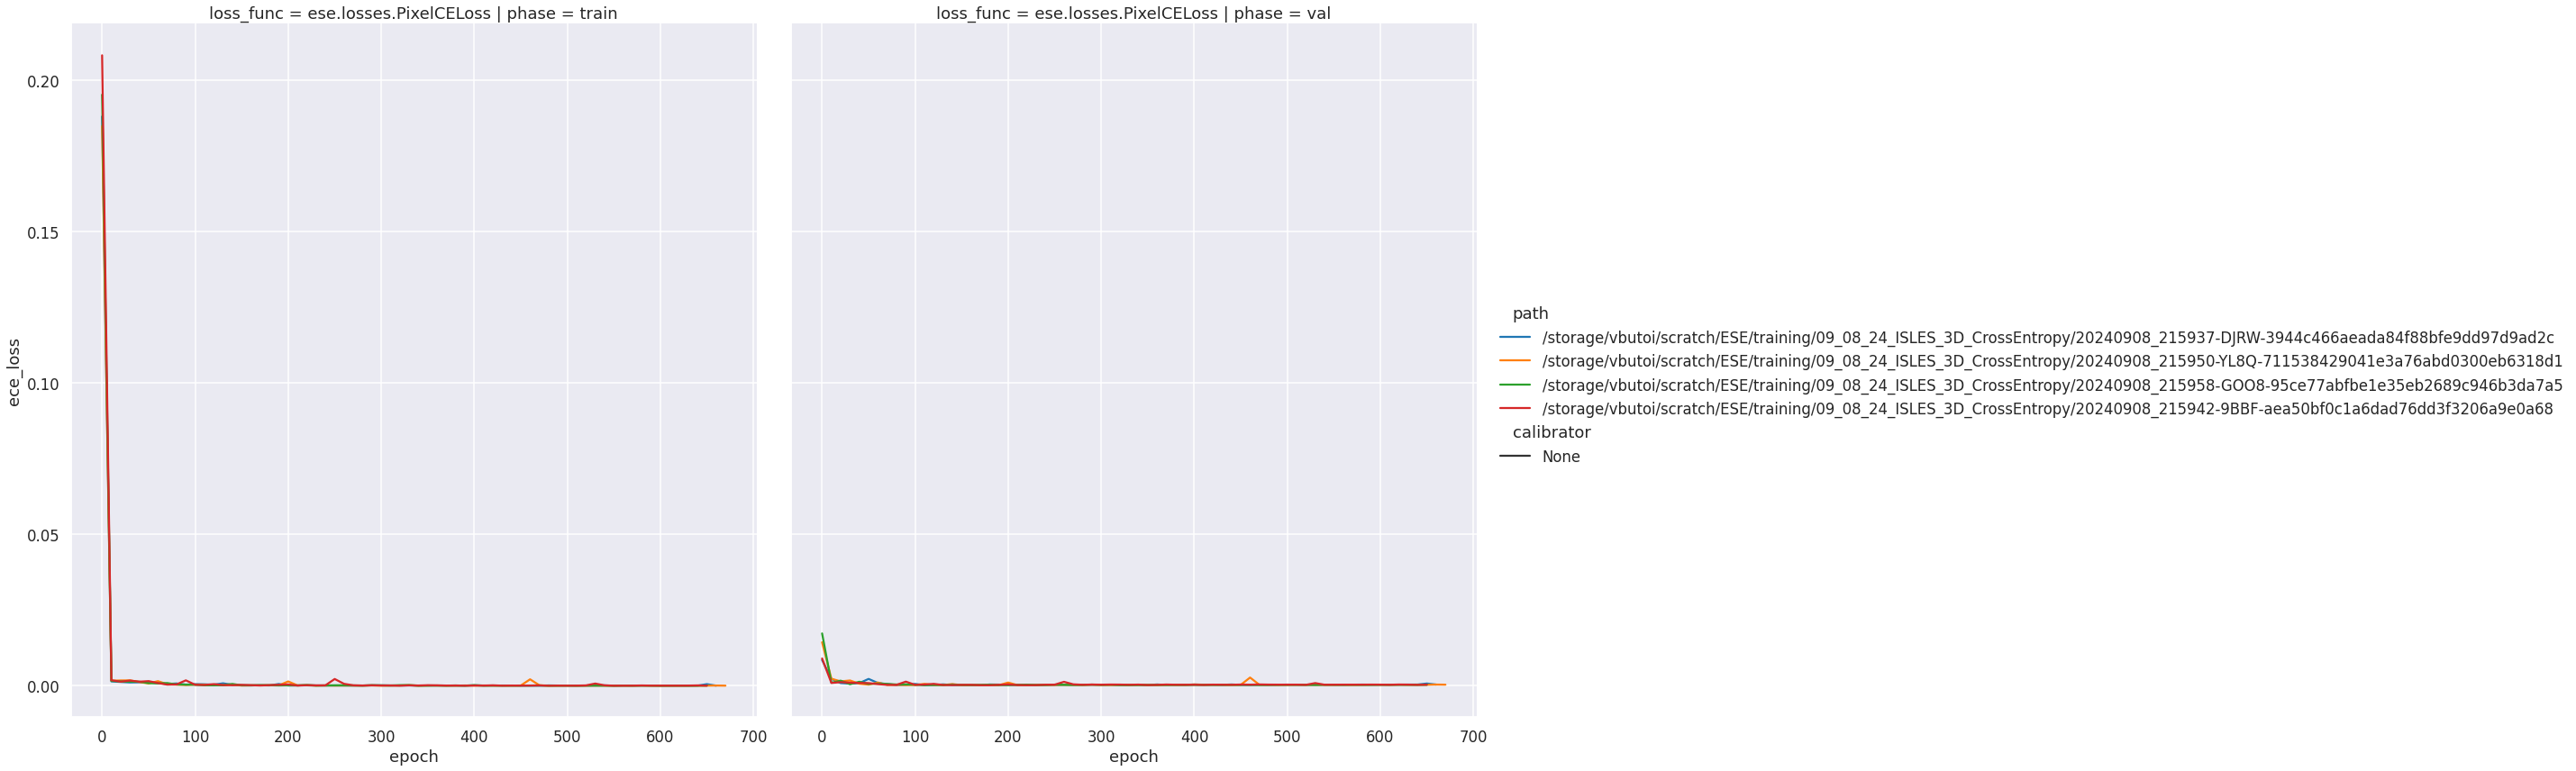

In [10]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='ece_loss',
    hue='path',
    # hue='seed',
    style='calibrator',
    row='loss_func',   
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

In [11]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='area_estimation_error',
    hue='path',
    # hue='seed',
    style='calibrator',
    row='loss_func',   
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

ValueError: Could not interpret value `area_estimation_error` for parameter `y`